In [ ]:
import tensorflow as tf
from IPython.display import Image, display
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model


In [ ]:
#dataset
train_path='xray_dataset_covid19/train'
test_path='xray_dataset_covid19/test'



train_data=ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_path,
    target_size=(224,224),
    classes=['normal','covid'],
    batch_size=32,
    class_mode='binary',
)


test_data=ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_path,
    target_size=(224,224),
    classes=['normal','covid'],
    batch_size=32,
    class_mode='binary',
)


Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
#model
input = tf.keras.Input(shape=(224,224,3))
xception= keras.applications.xception.Xception(weights='imagenet', include_top=False,input_tensor = input)
x=Conv2D(filters=128,kernel_size=(3,3), activation='relu')(xception.output)
x=Dropout(rate=0.25)(x)
x=Flatten()(x)
x=Dense(units=64, activation='relu')(x)
output=Dense(units=1,activation='sigmoid')(x)
model = tf.keras.Model(xception.input, output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
#compile and run

model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.fit(train_data, epochs=10,validation_data=test_data)


Epoch 1/10
5/5 [==============================] - 103s 21s/step - loss: 1.1774 - accuracy: 0.5743 - val_loss: 0.3605 - val_accuracy: 0.8000
Epoch 2/10
5/5 [==============================] - 89s 17s/step - loss: 0.6867 - accuracy: 0.7162 - val_loss: 0.3923 - val_accuracy: 0.9500
Epoch 3/10
5/5 [==============================] - 88s 17s/step - loss: 0.6026 - accuracy: 0.7568 - val_loss: 0.3691 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 92s 20s/step - loss: 0.4926 - accuracy: 0.8108 - val_loss: 0.8869 - val_accuracy: 0.7750
Epoch 5/10
5/5 [==============================] - 91s 18s/step - loss: 0.3930 - accuracy: 0.9257 - val_loss: 0.2220 - val_accuracy: 0.9500
Epoch 6/10
5/5 [==============================] - 89s 18s/step - loss: 0.2901 - accuracy: 0.9122 - val_loss: 0.4898 - val_accuracy: 0.9500
Epoch 7/10
5/5 [==============================] - 88s 17s/step - loss: 0.1635 - accuracy: 0.9527 - val_loss: 1.8280 - val_accuracy: 0.9000
Epoch 8/10
5/5 [==========

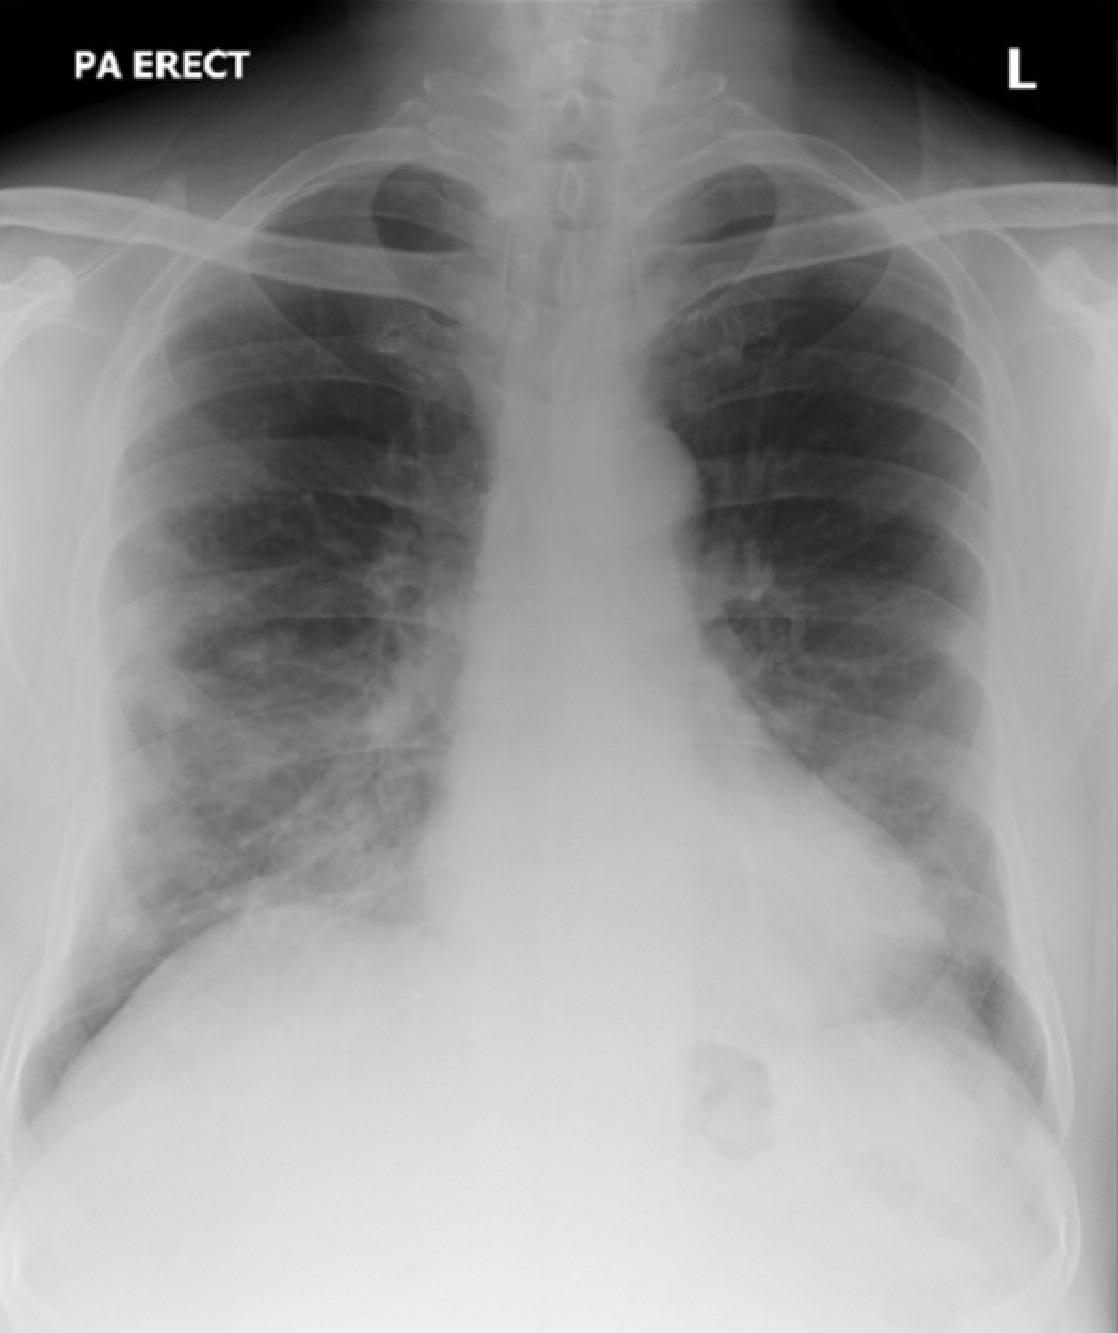

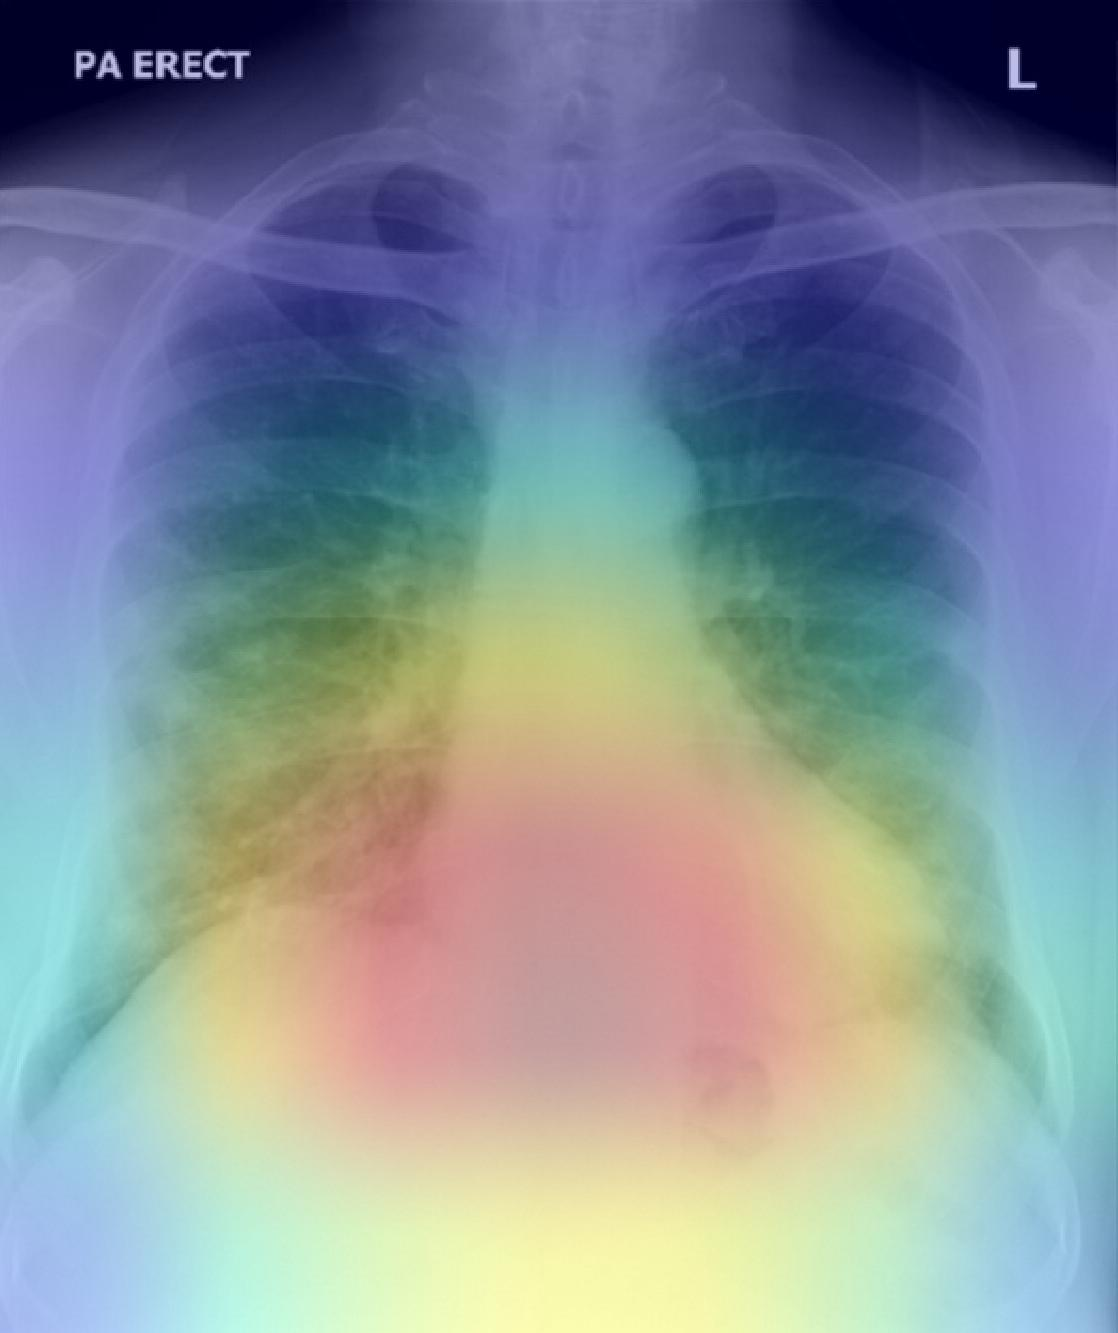

In [ ]:
IMAGE_SIZE=(224,224)
last_conv_layer_name = "block14_sepconv2_act"

img_path='xray_dataset_covid19/test/COVID/ryct.2020200034.fig5-day0.jpeg'

display(Image(img_path))


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=IMAGE_SIZE))

model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)



In [ ]:
from keras.preprocessing import image
img_path='xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg'
img=image.load_img(img_path, target_size=(224,224))
img=image.img_to_array(img)/255
img=np.array([img])
out=model.predict(img)
print(out)

[[-22.678144]]
